In [104]:
# from lgb2d, lgb imputer
mname = 'lgb2c'
path = './'
ncf = 0
ncd = 0

start = 400
stop = 550

importance_type = 'gain'
# importance_type = 'weight'
# importance_type = 'cover

In [105]:
import pandas as pd
import numpy as np
import gc, os
import time
import random
import matplotlib.pyplot as plt
import seaborn as sb
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', 100)

In [106]:
# main data table, specify D as a missing value for many of the numeric columns
a = pd.read_csv(path+'nuMoM2b_Dataset_NICHD Data Challenge.csv', low_memory=False, na_values='D')
a

,PublicID,A02_Complete,A02_Complete_1,A02_Status,A02_Status_1,A02Ver,A02Ver_1,A02DATE_INT,A02DATE_INT_1,A02A01,...,Unnamed: 11707,Unnamed: 11708,Unnamed: 11709,Unnamed: 11710,Unnamed: 11711,Unnamed: 11712,Unnamed: 11713,Unnamed: 11714,Unnamed: 11715,Unnamed: 11716
0,00001U,Complete,NaN,Passed,NaN,2,NaN,-197,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00004O,Complete,NaN,Passed,NaN,2,NaN,-199,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00007I,Complete,NaN,Passed,NaN,2,NaN,-208,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00008G,Complete,NaN,Passed,NaN,2,NaN,-205,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00015J,Complete,NaN,Passed,NaN,2,NaN,-198,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9284,17349I,Complete,NaN,Passed,NaN,2,NaN,-202,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9285,17350A,Complete,NaN,Passed,NaN,2,NaN,-219,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9286,17351V,Complete,NaN,Passed,NaN,2,NaN,-200,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9287,17352T,Complete,NaN,Passed,NaN,2,NaN,-196,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
# create survival target for xgboost, negative values indicate censoring
a['CMDA05A_INT'] = a['CMDA05A_INT'].apply(pd.to_numeric, errors='coerce')
a['CMDA05A_INT'].describe()

count    1988.000000
mean      -21.683099
std        30.949480
min      -143.000000
25%       -30.000000
50%       -11.000000
75%        -1.000000
max        18.000000
Name: CMDA05A_INT, dtype: float64

In [108]:
 a.CMDA05A_INT.isnull().value_counts()

True     7301
False    1988
Name: CMDA05A_INT, dtype: int64

In [109]:
a['censor'] = a.CMDA05A_INT.isnull().astype(int)
a.censor.describe()

count    9289.000000
mean        0.785983
std         0.410160
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: censor, dtype: float64

In [110]:
a.GAwksCA.describe()

count    8886.000000
mean       38.485483
std         3.402333
min         6.000000
25%        38.000000
50%        39.000000
75%        40.000000
max        43.000000
Name: GAwksCA, dtype: float64

<AxesSubplot:ylabel='Frequency'>

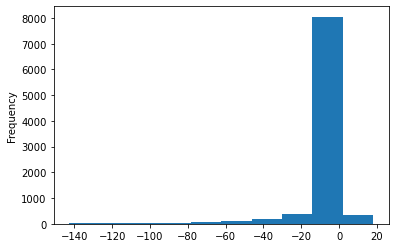

In [111]:
a['cmda05_days'] = a.CMDA05A_INT.fillna(0) + a.CMDA05a_HR.fillna(0)/24.0 + a.CMDA05a_MIN.fillna(0)/(24.0*60)
a.cmda05_days.plot.hist()

<AxesSubplot:ylabel='Frequency'>

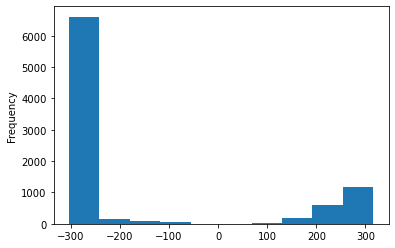

In [112]:
a['tthd'] = (7 * a.GAwksCA + a.GAdysCA + a.cmda05_days)*(1.0 - 2 * a.censor)
a.tthd.plot.hist()

In [113]:
a.tthd.describe()

count    8886.000000
mean     -155.557149
std       219.958845
min      -304.000000
25%      -282.000000
50%      -274.000000
75%      -234.000000
max       316.055556
Name: tthd, dtype: float64

In [114]:
# drop rows with missing target
# a = a[a.tthd.notnull()]
a.shape

(9289, 11720)

In [115]:
target = 'tthd'

In [116]:
a_food_onehot = a.loc[:,"FFQ_Date_int":"AHEI2010"].apply(lambda foodCol: pd.to_numeric(foodCol, errors="coerce")).fillna(0)
a_food_onehot

,FFQ_Date_int,JAN_PP,FEB_PP,MAR_PP,APR_PP,MAY_PP,JUN_PP,JUL_PP,AUG_PP,SEP_PP,...,AHEI_WGRAINS,AHEI_SUGBEVS,AHEI_NUTLEGS,AHEI_RMEATS,AHEI_TRFATPCT,AHEI_DHAEPA,AHEI_PUFAPCT,AHEI_SODIUM,AHEI_ALCDRKS,AHEI2010
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000000,0.0000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000
1,234.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.502,0.000000,4.4900,6.162236,7.478604,7.360,9.020737,6.962302,2.5,52.410880
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000000,0.0000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000
3,205.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.186,0.000000,3.3800,6.564417,7.673692,0.936,6.294495,6.954905,5.0,53.209509
4,198.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.002,5.366402,10.0000,5.310157,9.430597,5.400,10.000000,0.000000,5.0,70.084156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9284,202.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.860,0.000000,3.1650,4.669393,8.982259,3.596,4.476044,5.179470,2.5,40.753166
9285,229.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.816,0.000000,0.4909,1.567825,7.280527,1.052,8.100696,9.633505,5.0,38.578954
9286,200.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.294,9.155644,3.5790,8.588957,9.874415,3.496,6.962957,10.000000,5.0,61.258473
9287,196.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.956,0.000000,5.9600,7.600545,8.367089,9.040,8.911255,9.068236,10.0,68.488125


In [117]:
# map positive numbers to 1 and the others to 0
# a_food_onehot[a_food_onehot > 0] = 1 
# a_food_onehot[a_food_onehot <= 0] = 0 
# a_food_onehot = a_food_onehot.astype(int)
# a_food_onehot

In [118]:
# pd.unique(a_food_onehot.values.ravel("K")) # now there are only 0 and 1 s in the data. 

<AxesSubplot:ylabel='Frequency'>

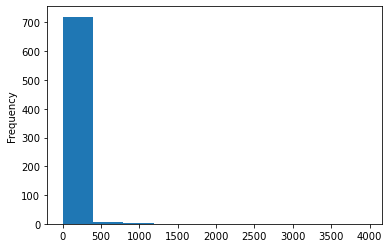

In [119]:
a_food_onehot.mean().plot.hist()

In [120]:
# pca on foods
from sklearn.decomposition import TruncatedSVD

if ncf > 0:
    tsvd = TruncatedSVD(n_components=ncf)

    a_food_onehot0 = a_food_onehot.copy()

    a_food_onehot = tsvd.fit_transform(a_food_onehot0)
    a_food_onehot = pd.DataFrame(a_food_onehot, columns = [f'food_svd{i}' for i in range(ncf)],
                                index=a_food_onehot0.index)
    a_food_onehot

#### One-hot Encoding for Drugs 

In [121]:
# check how many unique drug names in all the drug name columns 
drug_union = pd.unique(a[a.columns[a.columns.str.startswith("DrugName")]].values.ravel("K"))
len(drug_union)

625

In [122]:
print(drug_union) 
# note that nan is one of the drug names, so the real drug name number should be 624

[nan 'IBUPROFEN' 'FLUTICASONE' 'PRENATAL VITAMIN' 'LEVOTHYROXINE'
 'ADDERALL' 'SERTRALINE' 'DESVENLAFAXINE' 'VITAMIN D' 'UNKNOWN'
 'ACYCLOVIR' 'NAPROXEN' 'INFLUENZA VACCINE' 'OCP' 'ALBUTEROL'
 'TETANUS VACCINE' 'TOPIRAMATE' 'ERYTHROMYCIN' 'RANITIDINE' 'DHA'
 'FLUCONAZOLE' 'IRON' 'ACETAMINOPHEN/OXYCODONE' 'PENICILLIN' 'PPD'
 'ACETAMINOPHEN' 'CETIRIZINE' 'ENOXAPARIN' 'METFORMIN' 'PROMETHAZINE'
 'BUDESONIDE' 'CEPHALEXIN' 'ONDANSETRON' 'ROBITUSSIN' 'TERCONAZOLE'
 'METHYLDOPA' 'ASPIRIN/ACETAMINOPHEN/CAFFEINE' 'METRONIDAZOLE'
 'METHOTREXATE' 'CITALOPRAM' 'NITROFURANTOIN' 'FOLIC ACID' 'ASPIRIN'
 'LACTULOSE' 'BUPRENORPHINE/NALOXONE' 'LORATADINE' 'PREDNISONE'
 'OMEPRAZOLE' 'LISDEXAMFETAMINE' 'ESTROGEN' 'AZELAIC ACID' 'BUPROPION'
 'FLUOXETINE' 'HYDROXYCHLOROQUINE' 'AMOXICILLIN' 'MULTIVITAMIN'
 'MICONAZOLE' 'LEVETIRACETAM' 'VERAPAMIL' 'MESALAMINE' 'VALACYCLOVIR'
 'VITAMIN B-6' 'AZITHROMYCIN' 'RIZATRIPTAN' 'INSULIN' 'ZOLPIDEM'
 'VENLAFAXINE' 'CALCIUM' 'LABETALOL' 'MONTELUKAST' 'METOCLOPRAMIDE'
 'D

In [123]:
a_drug_onehot = pd.get_dummies(a[a.columns[a.columns.str.startswith("DrugName")]], prefix="DrugName").max(axis=1, level=0)
a_drug_onehot

,DrugName_ACETAMINOPHEN,DrugName_ACETAMINOPHEN/BUTALBITAL/CAFFEINE,DrugName_ACETAMINOPHEN/CAFFEINE,DrugName_ACETAMINOPHEN/CODEINE,DrugName_ACETAMINOPHEN/DIPHENHYDRAMINE,DrugName_ACETAMINOPHEN/HYDROCODONE,DrugName_ACETAMINOPHEN/OXYCODONE,DrugName_ACYCLOVIR,DrugName_ADALIMUMAB,DrugName_ADDERALL,...,DrugName_ROCURONIUM,DrugName_SUCCINYLCHOLINE,DrugName_CISATRACURIUM,DrugName_NEOSTIGMINE,DrugName_DEXTROSE,DrugName_DORNASE ALFA,DrugName_OLMESARTAN,DrugName_DRONABINOL,DrugName_INDIGO CARMINE,DrugName_MEROPENEM
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:ylabel='Frequency'>

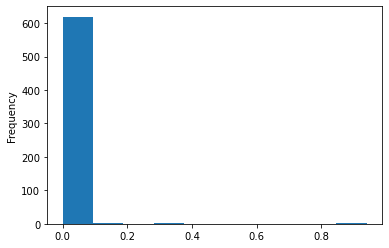

In [124]:
a_drug_onehot.mean().plot.hist()

In [125]:
# pca on drugs
# from sklearn.decomposition import TruncatedSVD

if ncd > 0:
    tsvd = TruncatedSVD(n_components=ncd)

    a_drug_onehot0 = a_drug_onehot.copy()

    a_drug_onehot = tsvd.fit_transform(a_drug_onehot0)
    a_drug_onehot = pd.DataFrame(a_drug_onehot, columns = [f'drug_svd{i}' for i in range(ncd)],
                                index=a_drug_onehot0.index)
    a_drug_onehot

In [126]:
# !pip install xlrd
# !pip install openpyxl

In [127]:
# column groups
b = pd.read_excel(path+'nuMoM2b Dataset Information.xlsx', header=2)
b

,No.,Dataset Name,Dataset Title,Keywords,Total # of Columns,Total # of Rows,Corresponding Case Report Form (CRF) Name,CRF Study Timepoint,CRF Section Heading Names,Relevance to Maternal Morbidity (Y/N),Comments,Unnamed: 11
0,1,a02,nuMoM2b Elements of Consent [A02] Dataset,Informed consent; Assent,32,9290,nuMoM2b_A02_Elements of Consent_2010-09-27.pdf,Administrative/Screening,A. Administration of Informed Consent\nB. Elements of Informed Consent,N,CRF is about whether consent to participant was obtained and level of consent,NaN
1,2,a03,nuMoM2b Protocol Deviations [A03] Dataset,Protocol deviation,18,301,nuMoM2b_A03_Protocol Deviations_2010-09-27.pdf,Administrative/Overall,A. Details on Deviations(s),N,"CRF is about protocol deviations (e.g., failure to obtain consent, breach of confidentiality)",NaN
2,3,a04,nuMoM2b Adverse Event [A04] Dataset,Adverse event,14,72,nuMoM2b_A04_Adverse Event_2010-09-27.pdf,Administrative/Overall,A. Details on Event,Y,"Information such as participant death, suicidal ideation, and other adverse events captured",NaN
3,4,a05,nuMoM2b Study Withdrawal [A05] Dataset,Study withdrawal; Study discontinuation,27,304,nuMoM2b_A05_Study Withdrawal_2010-09-27.pdf,Administrative/Overall,A. Study Withdrawal,Y,"Information such as participant unable to continue due to medical condition, death, and other wi...",NaN
4,5,a09,nuMoM2b Brief Report of Pregnancy Outcome [A09] Dataset,Pregnancy outcome; Complications,18,9216,nuMoM2b_A09_Report of Pregnancy Outcome_2012-02-16.pdf,Administrative/Overall,A. Outcome Information,Y,Preterm birth and maternal hypertension indicated,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
74,75,v3j,nuMoM2b Brief Pregnancy Experience Scale (PES) Visit 3 [V3J] Dataset,Feelings; Emotions,26,8181,nuMoM2b_V3J_Brief Pregnancy Experience Scale (PES) Visit 3_2010-09-27_redacted.pdf,Visit 3,A. Pregnancy Experience,Y,Information on pregnancy experiences (Note: CRF redacted since proprietary),NaN
75,76,v3k,nuMoM2b Sleep Monitoring Following Visit 3 [V3K] Dataset,Sleep time; Sleep length; Sleep position; Sleep quality,30,2450,nuMoM2b_V3K_Portable Sleep Assessment Questionnaire Visit 3_2011-01-17.pdf,Sleep Disordered Breathing (SDB) Substudy,A. Time Spent Sleeping\nB. Sleep Quality,Y,"Self-assessment of sleep time, quality, and position after using the sleep monitor at home",NaN
76,77,v3l,nuMoM2b Revised Sleep Questionnaire Visit 3 [V3L] Dataset,Sleep habits; Snoring; Sleep issues; Sleep quality; Sleep position,66,7816,nuMoM2b_V3L_Revised Sleep Questionnaire Visit 3_2011-01-17_redacted.pdf,Visit 3,A. General Work and Sleep Patterns\nB. Sleep Habits\nC. Sleepiness\nD. Symptoms of Restless Legs...,Y,"Information on sleep quality, issues, and disorders (Note: CRF replaced V3F)",NaN
77,78,v4a,nuMoM2b Delivery Maternal Interview [V4A] Dataset,Hospital; Labor; Induction; Cesarean section; Illnesses; Activity restriction; Substance use,137,6662,nuMoM2b_V4A_Maternal_Interview Delivery_2011-12-09.pdf,Delivery Visit,A. Interview Administration\nB. Verification of Participant Identity\nC. Medical Provider Inform...,Y,"Hospitalization information, delivery details and complications, activity before delivery, and l...",NaN


In [128]:
# column labels
c = pd.read_excel(path+'nuMoM2b_Codebook_NICHD Data Challenge.xlsx', header=1)
c

,Original Dataset Name,Variable Name,Variable Label,Variable Type,Variable Unit\n(if Numeric),Variable Code List\n(if Coded),Unnamed: 6
0,NaN,PublicID,Public nuMoM2b ID,Character,NaN,NaN,NaN
1,a02,A02_Complete,(A02) Data entry status,Character,NaN,NaN,NaN
2,a02,A02_Complete_1,(A02) Data entry status,Character,NaN,NaN,NaN
3,a02,A02_Status,(A02) Validation status,Character,NaN,NaN,NaN
4,a02,A02_Status_1,(A02) Validation status,Character,NaN,NaN,NaN
...,...,...,...,...,...,...,...
11612,vxx,VXXC01j_045,(VXX) Medications and vaccinations (45) - Source: Chart abstraction (checkbox),Coded,NaN,Checked,NaN
11613,vxx,VXXC01k_045,(VXX) Medications and vaccinations (45) - Final assessment: Took medication/vaccine (checkbox),Coded,NaN,Checked,NaN
11614,vxx,VXXC02a,(VXX) How long have you been taking [perinatal vitamins/other multivitamins/ folate supplements]...,Numeric,Weeks,NaN,NaN
11615,vxx,VXXC02b,(VXX) How long have you been taking [perinatal vitamins/other multivitamins/ folate supplements]...,Numeric,Months,NaN,NaN


In [129]:
clab = c[['Original Dataset Name', 'Variable Name','Variable Label']]
clab.columns = ['dataset','feature','label']
clab = clab.set_index('feature')
clab

,dataset,label
feature,,
PublicID,NaN,Public nuMoM2b ID
A02_Complete,a02,(A02) Data entry status
A02_Complete_1,a02,(A02) Data entry status
A02_Status,a02,(A02) Validation status
A02_Status_1,a02,(A02) Validation status
...,...,...
VXXC01j_045,vxx,(VXX) Medications and vaccinations (45) - Source: Chart abstraction (checkbox)
VXXC01k_045,vxx,(VXX) Medications and vaccinations (45) - Final assessment: Took medication/vaccine (checkbox)
VXXC02a,vxx,(VXX) How long have you been taking [perinatal vitamins/other multivitamins/ folate supplements]...


In [130]:
# column codes
c1 = pd.read_excel(path+'nuMoM2b_Codebook_NICHD Data Challenge.xlsx', sheet_name=1)
c1

,Code List Name,Value,Value Label
0,Activity_Code,1,Aerobics Class/Exercise Machines
1,Activity_Code,2,Basketball
2,Activity_Code,3,Bowling
3,Activity_Code,4,Calisthenics/Home or Gym Exercise
4,Activity_Code,5,Canoeing/Rowing/Sailing
...,...,...,...
1540,Yes_No_v10,2,"Yes, temporarily"
1541,Yes_No_v10,3,No
1542,Zygosity,1,Present heterozygote
1543,Zygosity,2,Present homozygote


In [131]:
# feature sets
s = pd.Series(c.groupby('Original Dataset Name')['Variable Name'], dtype=object)
s

0     (a02, [A02_Complete, A02_Complete_1, A02_Status, A02_Status_1, A02Ver, A02Ver_1, A02DATE_INT, A0...
1     (a03, [A03_FormNumber, A03_FormNumber_1, A03_FormNumber_2, A03_Complete, A03_Complete_1, A03_Com...
2     (a04, [A04_FormNumber, A04_FormNumber_1, A04_Complete, A04_Complete_1, A04_Status, A04_Status_1,...
3     (a05, [A05_Complete, A05_Status, A05Ver, A05DATE_INT, A05A01_INT, A05A02a, A05A02b, A05A02c, A05...
4     (a09, [A09_Complete, A09_Status, A09Ver, A09DATE_INT, A09A01_Check, A09A01_INT, A09A02, A09A03a,...
                                                     ...                                                 
74    (v3j, [V3J_Complete, V3J_Status, V3JVer, V3JDATE_INT, V3JA01a, V3JA01b, V3JA01c, V3JA01d, V3JA01...
75    (v3k, [V3K_Complete, V3K_Status, V3KVer, V3KDATE_INT, V3KA01_HR, V3KA01_MIN, V3KA01_AMPM, V3KA02...
76    (v3l, [V3L_Complete, V3L_Status, V3LVer, V3LDATE_INT, V3LA01, V3LA01a, V3LA01b, V3LA02a, V3LA02b...
77    (v4a, [V4A_Complete, V4A_Status, V4AVer,

In [132]:
# feature set dictionary
fd = {}
for k,v in s:
    fd[k] = list(v.values)
print(fd.keys())
print()
print(fd['a09'])

dict_keys(['a02', 'a03', 'a04', 'a05', 'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a33', 'a34', 'a35', 'af1', 'af2', 'af3', 'af4', 'af5', 'af6', 'af7', 'cba', 'cbb', 'cbc', 'cla', 'clb', 'cma', 'cmb', 'cmc', 'cmd', 'cme', 'cpa', 'cua', 'cub', 'demographics', 'drugs_in_pregnancy', 'e2c', 'food_frequency_analysis', 'physical_activity', 'placental_analytes', 'pregnancy_outcomes', 's01', 's02', 'sample_selection', 'sleep_actigraphy', 'sleep_actigraphy_modified', 'sleep_disordered_breathing', 'u02', 'u1c', 'u2a', 'u2b', 'u2c', 'u3a', 'u3b', 'u3c', 'u3d', 'v1a', 'v1b', 'v1c', 'v1e', 'v1f', 'v1g', 'v1h', 'v1k', 'v1l', 'v2a', 'v2b', 'v2i', 'v2m', 'v3a', 'v3b', 'v3c', 'v3e', 'v3f', 'v3j', 'v3k', 'v3l', 'v4a', 'vxx'])

['A09_Complete', 'A09_Status', 'A09Ver', 'A09DATE_INT', 'A09A01_Check', 'A09A01_INT', 'A09A02', 'A09A03a', 'A09A03a1', 'A09A03a1_sp', 'A09A03a1a', 'A09A03a1b', 'A09A03b', 'A09A03b1', 'A09A03b2', 'A09A03b3']


In [133]:
# feature sets to use, limit to information available on or before visit 1
fs = ['cla','demographics','s01','s02','u02','u1c','v1a', 'v1b', 'v1c', 'v1e', 'v1f', 'v1g', 'v1h', 'v1k', 'v1l']
# fs = ['cla','demographics','v1b']
# fs = ['cla','demographics','u02','v1b','v1l']
# fs = ['cla','demographics','s01','s02','u02','v1b','v1l']
# fs = ['cla','demographics','u02','v1b','v1l','v1g']
# fs = ['cla','demographics','s01','u02','v1b','v1l']
fs = fs + ['v2a', 'v2b', 'v2i', 'v2m']

In [134]:
import warnings
warnings.filterwarnings('ignore')

In [135]:
# missing from data but in feature set
nlist = ['V1AF08_D', 'V2AF06_D', 'V2AF09_D', 'V2AF19_D', 'V2AF23_D', 'V2AF26_D']
for n in nlist: a[n] = np.nan

In [136]:
# coerce to numeric
for s in fs:
    print(s)
    a.loc[:,fd[s]] = a.loc[:,fd[s]].apply(pd.to_numeric, errors='coerce')

cla
demographics
s01
s02
u02
u1c
v1a
v1b
v1c
v1e
v1f
v1g
v1h
v1k
v1l
v2a
v2b
v2i
v2m


In [137]:
a.V1BA03a.describe()

count    9014.000000
mean       83.087022
std        13.377050
min        29.600000
25%        74.000000
50%        80.000000
75%        89.500000
max       157.000000
Name: V1BA03a, dtype: float64

In [138]:
# feature engineering
nc = a.shape[1]
print(nc)
a['Height_mean'] = a[['V1BA02a','V1BA02b','V1BA02c']].mean(axis=1)
a['Waist_mean'] = a[['V1BA03a','V1BA03b','V1BA03c']].mean(axis=1)
a['Waist_iliac_mean'] = a[['V1BA04a','V1BA04b','V1BA04c']].mean(axis=1)
a['Hip_mean'] = a[['V1BA05a','V1BA05b','V1BA05c']].mean(axis=1)
a['BP_Sys_mean'] = a[['V1BA06a1','V1BA06b1']].mean(axis=1)
a['BP_Dia_mean'] = a[['V1BA06b1','V1BA06b2']].mean(axis=1)
a['Neck_mean'] = a[['V1BA07a','V1BA07b','V1BA07c']].mean(axis=1)

a['Height_std'] = a[['V1BA02a','V1BA02b','V1BA02c']].std(axis=1)
a['Waist_std'] = a[['V1BA03a','V1BA03b','V1BA03c']].std(axis=1)
a['Waist_iliac_std'] = a[['V1BA04a','V1BA04b','V1BA04c']].std(axis=1)
a['Hip_std'] = a[['V1BA05a','V1BA05b','V1BA05c']].std(axis=1)
a['BP_Sys_std'] = a[['V1BA06a1','V1BA06b1']].std(axis=1)
a['BP_Dia_std'] = a[['V1BA06b1','V1BA06b2']].std(axis=1)
a['Neck_std'] = a[['V1BA07a','V1BA07b','V1BA07c']].std(axis=1)

a['Height_max'] = a[['V1BA02a','V1BA02b','V1BA02c']].max(axis=1)
a['Waist_max'] = a[['V1BA03a','V1BA03b','V1BA03c']].max(axis=1)
a['Waist_iliac_max'] = a[['V1BA04a','V1BA04b','V1BA04c']].max(axis=1)
a['Hip_max'] = a[['V1BA05a','V1BA05b','V1BA05c']].max(axis=1)
a['BP_Sys_max'] = a[['V1BA06a1','V1BA06b1']].max(axis=1)
a['BP_Dia_max'] = a[['V1BA06b1','V1BA06b2']].max(axis=1)
a['Neck_max'] = a[['V1BA07a','V1BA07b','V1BA07c']].max(axis=1)


drop = ['V1BA02a','V1BA02b','V1BA02c'] + ['V1BA03a','V1BA03b','V1BA03c'] + \
       ['V1BA04a','V1BA04b','V1BA04c'] +['V1BA05a','V1BA05b','V1BA05c'] + \
       ['V1BA06a1','V1BA06b1'] + ['V1BA06b1','V1BA06b2'] + ['V1BA07a','V1BA07b','V1BA07c']

# a['BP_Diff1'] = a.V1BA06a1 - a.V1BA06b1
# a['BP_Ratio1'] = a.V1BA06a1 / a.V1BA06b1
# a['WH_Ratio1'] = a.V1BA01_LB / a.V1BA02a
# a['WW_Ratio1'] = a.V1BA01_LB / a.V1BA03a
# a['WI_Ratio1'] = a.V1BA01_LB / a.V1BA04a
# a['WP_Ratio1'] = a.V1BA01_LB / a.V1BA05a
# a['WN_Ratio1'] = a.V1BA01_LB / a.V1BA07a
# a['BMIS_Ratio1'] = a.BMI / a.V1BA06a1
# a['BMID_Ratio1'] = a.BMI / a.V1BA06b1

11726


<AxesSubplot:ylabel='Frequency'>

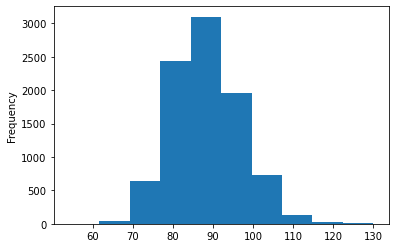

In [139]:
a.BP_Sys_mean.plot.hist()

<AxesSubplot:ylabel='Frequency'>

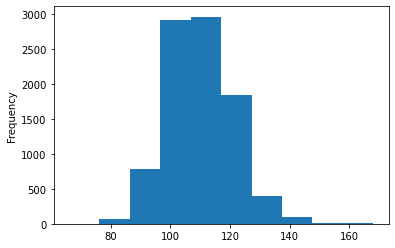

In [140]:
a.BP_Sys_max.plot.hist()

In [141]:
a.BP_Sys_mean.describe()

count    9087.000000
mean       88.109222
std         8.573187
min        54.000000
25%        82.000000
50%        87.500000
75%        94.000000
max       130.000000
Name: BP_Sys_mean, dtype: float64

In [142]:
a.BP_Sys_max.describe()

count    9087.000000
mean      109.210631
std        10.938519
min        66.000000
25%       100.000000
50%       110.000000
75%       118.000000
max       168.000000
Name: BP_Sys_max, dtype: float64

In [143]:
a.BP_Dia_mean.describe()

count    9087.000000
mean       66.980907
std         8.283447
min        30.000000
25%        60.000000
50%        68.000000
75%        72.000000
max       101.000000
Name: BP_Dia_mean, dtype: float64

In [144]:
a.BP_Sys_std.describe()

count    9087.000000
mean       29.841898
std         6.530458
min         0.000000
25%        25.455844
50%        29.698485
75%        33.941125
max        73.539105
Name: BP_Sys_std, dtype: float64

In [145]:
# new feature set with engineered features
ef = a.columns[nc:]
ef

Index(['Height_mean', 'Waist_mean', 'Waist_iliac_mean', 'Hip_mean',
       'BP_Sys_mean', 'BP_Dia_mean', 'Neck_mean', 'Height_std', 'Waist_std',
       'Waist_iliac_std', 'Hip_std', 'BP_Sys_std', 'BP_Dia_std', 'Neck_std',
       'Height_max', 'Waist_max', 'Waist_iliac_max', 'Hip_max', 'BP_Sys_max',
       'BP_Dia_max', 'Neck_max'],
      dtype='object')

In [146]:
fd['eng'] = ef
fs = fs + ['eng']

In [147]:
a.V1AE2_04c_4.dtype

dtype('float64')

In [148]:
# drop columns with high percentage of missing values
print(a.shape)
pthresh = 0.2
a = a.dropna(axis=1, thresh=int(pthresh*len(a)))
print(a.shape)

(9289, 11747)
(9289, 4271)


In [149]:
# join one-hots
fd['food'] = list(a_food_onehot.columns)
fd['drug'] = list(a_drug_onehot.columns)
# fs = fs + ['food','drug']

In [150]:
# adrop = [c for c in a.columns if (c in fd['food']) or c.startswith('DrugName')]
# print(a.shape, len(adrop))
# a = a.drop(columns=adrop)
# print(a.shape)
# a = pd.concat([a, a_food_onehot, a_drug_onehot], axis=1)
# print(a.shape)

In [151]:
# flab = pd.DataFrame({'feature':fd['food'],'dataset':'food','label':fd['food']}).set_index('feature')
# dlab = pd.DataFrame({'feature':fd['drug'],'dataset':'drug','label':fd['drug']}).set_index('feature')
# clab = pd.concat([clab,flab,dlab])
clab

,dataset,label
feature,,
PublicID,NaN,Public nuMoM2b ID
A02_Complete,a02,(A02) Data entry status
A02_Complete_1,a02,(A02) Data entry status
A02_Status,a02,(A02) Validation status
A02_Status_1,a02,(A02) Validation status
...,...,...
VXXC01j_045,vxx,(VXX) Medications and vaccinations (45) - Source: Chart abstraction (checkbox)
VXXC01k_045,vxx,(VXX) Medications and vaccinations (45) - Final assessment: Took medication/vaccine (checkbox)
VXXC02a,vxx,(VXX) How long have you been taking [perinatal vitamins/other multivitamins/ folate supplements]...


In [152]:
# assemble features
features = []
for s in fs: features.extend(fd[s])
# restrict to numeric features, remove _INT dates
features = [f for f in features if ((f in a.columns) and (a[f].dtype != 'O') and (f[-4:]!='_INT')) and \
           (f not in drop)]

# drop second and third trimester features
features = [f for f in features if f[:4] not in ['CLAC','CLAD']]

features[:10], features[-10:], len(features)

(['CLAVer',
  'CLAA01a',
  'CLAA01b',
  'CLAA01c',
  'CLAA01d',
  'CLAA02',
  'CLAA03',
  'CLAA04',
  'CLAA05',
  'CLAA06'],
 ['Hip_std',
  'BP_Sys_std',
  'Neck_std',
  'Height_max',
  'Waist_max',
  'Waist_iliac_max',
  'Hip_max',
  'BP_Sys_max',
  'BP_Dia_max',
  'Neck_max'],
 654)

In [153]:
# # standardize features
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# d.loc[:,features] = scaler.fit_transform(d[features].values)

In [154]:
# save preprocessed data
# cols = ['PublicID',target] + features
# fname = mname + '.csv'
# a[cols].to_csv(fname, index=False)
# print(fname, a[cols].shape)

In [155]:
# training and test data
x = a[features]
y = a[target]
print(x.shape, y.shape)

(9289, 654) (9289,)


In [156]:
np.mean(x)

CLAVer               3.933423
CLAA01a             12.921480
CLAA01b             38.040291
CLAA01c             89.458561
CLAA01d            253.540454
                      ...    
Waist_iliac_max     95.056257
Hip_max            104.342963
BP_Sys_max         109.210631
BP_Dia_max          67.025421
Neck_max            32.956357
Length: 654, dtype: float64

In [157]:
np.mean(y)

-155.5571493547903

In [158]:
### Make colorful output ###
from colorama import Fore
c_ = Fore.CYAN
m_ = Fore.MAGENTA
r_ = Fore.RED
b_ = Fore.BLUE
y_ = Fore.YELLOW
g_ = Fore.GREEN

In [159]:
os.makedirs(path+'mod', exist_ok=True)
os.makedirs(path+'oof', exist_ok=True)
os.makedirs(path+'imp', exist_ok=True)
os.makedirs(path+'sub', exist_ok=True)
os.makedirs(path+'cvr', exist_ok=True)

In [160]:
# !pip install lightgbm --upgrade
# !pip install xgboost --upgrade

In [161]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [162]:
y.describe()

count    8886.000000
mean     -155.557149
std       219.958845
min      -304.000000
25%      -282.000000
50%      -274.000000
75%      -234.000000
max       316.055556
Name: tthd, dtype: float64

In [163]:
# Harrell's C concordance index, AUC for survival, sorting efficiency
# https://github.com/jameslu01/Compute_HazRatio_ML/blob/main/XGB_Code_Data/Breast%20Cancer/BreastCancer_Dataset_HR_Estimations_Manuscript_Mean.ipynb
def c_statistic_harrell(labels, pred):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if int(labels[j]) > 0 and abs(int(labels[i])) > int(labels[j]):
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

In [164]:
from sklearn.metrics import make_scorer
c_scorer = make_scorer(c_statistic_harrell)

<AxesSubplot:ylabel='Frequency'>

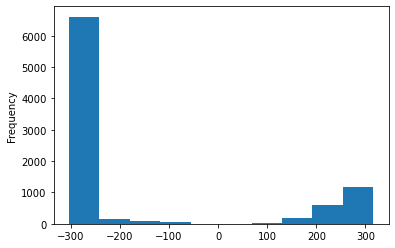

In [165]:
y.plot.hist()

In [166]:
features0 = features
nf = len(features0)
print(nf)

654


In [167]:
N_SPLITS = 7
N_REPEATS = 7
N_TRIES = 7
seed = 312
folds = []
for i in range(N_REPEATS):
    folds.extend(list(StratifiedKFold(n_splits=N_SPLITS, random_state=i+seed, shuffle=True).split(x, (y > 0))))
print(len(folds))

49


In [168]:
# Cross Validation
# %%time
def fitModel(folds, x, y, model, params, n_iter, scoring, cv, verbose = 0):
    global BOUND
    scores = []; y_preds = []; test_preds = []; models = []
    start = time.time()
    
    for fold_idx, fold in enumerate(folds[:N_REPEATS * N_SPLITS]):
        
        foldi = fold_idx // N_SPLITS
        foldj = fold_idx % N_SPLITS

        # print()
        # print("Fold", foldi, foldj)
         
        BOUND = random.random() * 0.7 + 0.3
        clf = RandomizedSearchCV(model, params, n_iter = n_iter,
            scoring = scoring, n_jobs = -1,
            cv = cv
        )
        xr = x.iloc[fold[0]].copy()
        # for col in random.sample(list(x.columns), k = int(0.05 * len(x.columns))):
        # xr[col] = 0

        # for col in [c for c in x.columns if 'DrugTest' in c][:5]:
        # xr[col] *= np.exp(np.random.normal(0, 0.1, len(xr)))\


        clf.fit(xr, y.iloc[fold[0]])
        # display(pd.DataFrame(clf.cv_results_).sort_values('rank_test_score'))

        model = clf.best_estimator_
        models.append(model)
        
        # requires python 3.8, walrus operator
        # models.append(model := clf.best_estimator_)
        
        # y_pred = ( (clf.predict_proba if hasattr(clf, 'predict_proba') else clf.predict)
        #     (x.iloc[fold[1]]) )
        y_pred = ( (model.predict_proba if hasattr(model, 'predict_proba') else model.predict)
            (x.iloc[fold[1]]) )

        y_pred = y_pred[:, -1] if len(y_pred.shape) == 2 else y_pred

        score = mean_squared_error(y.iloc[fold[1]], ( y_pred ) )
        scores.append( score )

        # requires python 3.8, walrus operator
        # scores.append( score := mean_squared_error(y.iloc[fold[1]], ( y_pred ) ) )

        y_preds.append( pd.Series(y_pred, index = x.iloc[fold[1]].index ) )
        # print('{:.4f}'.format(score))
        # break

        if (fold_idx + 1) % N_SPLITS == 0:
            print(c_)
            print('Running average after {} repeats: {:.4f}'.format( fold_idx // N_SPLITS + 1, np.mean(scores)) )
            yp = pd.concat(y_preds)
            yp = yp.groupby(yp.index).mean()
            print('Blended average after {} repeats: {:.4f}'.format( fold_idx // N_SPLITS + 1,
                mean_squared_error( yp.reindex(y.index), y ) ) )
            print('{:.1f}s'.format(time.time() - start))
            print(c_)

            if verbose >= 3:
                # print(models[-5:])
                print(models[-1])
           
        # test preds
        if len(x_test):
            test_pred = ( (model.predict_proba if hasattr(model, 'predict_proba') else model.predict)
                (x_test))
            test_pred = test_pred[:, -1] if len(test_pred.shape) == 2 else test_pred       
            # preds_test = model.predict(x_test)
            # preds_test = model.predict_proba(x_test)[:,-1]
            test_preds.append(test_pred)

    # save oofs
    yp = pd.concat(y_preds)
    yp = yp.groupby(yp.index).mean()
    # fname = f'oof/{mname}.pkl'
    # yp.to_pickle(fname)
    # print(fname, yp.shape)
    
    # save test set predictions
    if len(x_test):
        tp = np.stack(test_preds)
        tps = len(tp.shape)
        if tps==2:
            tp = np.mean(tp,axis=0)
        else:
            tp = np.mean(tp,axis=(0,2))
        # fname = f'sub/{mname}.npy'
        # np.save(fname, tp)
        # print(fname, tp.shape)
    else:
        tp = None
    
    return models, scores, yp, tp

In [169]:
params = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7],
    'n_estimators': [ 50, 100, 150, 225, 350 ],  
    'min_split_gain': [0, 0, 1e-4, 1e-3, 1e-2, 0.1],
    'min_child_samples': [ 1, 2, 4, 7, 10, 20, 30, 40, 70, 100],
    'min_child_weight': [0],
    'num_leaves': [  20, 30, 50, 100],
    'learning_rate': [0.05, 0.07, 0.1],         
    'colsample_bytree': [0.33, 0.5, 0.65, 0.8, 0.9, 1.0], 
    'colsample_bynode':[0.33, 0.5, 0.65, 0.81, 0.9, 1.0],
    'reg_lambda': [0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100 ],
    'reg_alpha': [0, 1e-3, 1e-2, 0.1, 1, 10], 
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'subsample_freq': [1],
    # 'max_bin': [50, 90, 125, 175, 255],
}      

In [170]:
# models, scores, y_preds, test_preds = fitModel(x, y, 
#     lgb.LGBMRegressor(), params, 20,
#     'neg_mean_squared_error', StratifiedKFold(n_splits = 5, shuffle = True), verbose = 5)

# models, scores, y_preds, test_preds = fitModel(x, y,
#     lgb.LGBMClassifier(), params, 10,
#     'neg_brier_score', StratifiedKFold(n_splits = 5, shuffle = True), verbose = 5)

In [171]:
import warnings
warnings.filterwarnings("ignore")

In [172]:
drop = [
    'PublicID', 
]


In [ ]:
# loop over all features, impute missing values with lgb
rez = a[['PublicID']].copy()
n = len(a)
for i,target in enumerate(features0):
        
    if target in drop: continue
    if i < start: continue
    if i >= stop: continue
    
    miss = a[target].isnull()
    nmiss = miss.sum()
    # if nmiss==0: continue
        
    nu = a[target].nunique()
    
    if nu <= 2: continue
    
    print(g_)
    print('+'*60)
    print(f'{i+1}/{nf}',target,nu,f'{nmiss/n:.3f}')
    print('+'*60)
    print(c_)
    
    features = [f for f in features0 if f != target]
    
    # training and test data based on missingness
    d = a[~miss]
    t = a[miss]
    print(d.shape, t.shape)
    
    x = d[features]
    y = d[target]
    x_test = t[features]
    print(x.shape, y.shape, x_test.shape)
    
    folds = []
    
    if nu==2: 
        est = lgb.LGBMClassifier()
        loss = 'neg_brier_score'
        # loss = 'brier_score_loss'
        y = y.astype(int)
        for i in range(N_REPEATS):
            folds.extend(list(StratifiedKFold(n_splits=N_SPLITS, random_state=i+seed, shuffle=True).split(x, y)))
        kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)
    else: 
        est = lgb.LGBMRegressor()
        loss = 'neg_mean_squared_error'
        for i in range(N_REPEATS):
            folds.extend(list(KFold(n_splits=N_SPLITS, random_state=i+seed, shuffle=True).split(x, y)))
        kf = KFold(n_splits=N_SPLITS, shuffle=True)
        
    models, scores, yp, tp = fitModel(folds, x, y, est, params, N_TRIES, loss, kf, verbose=5)

    imp = [pd.DataFrame({'feature':features,'gain':m.feature_importances_}) for m in models]
    imp = pd.concat(imp).groupby('feature').mean()
    imp.sort_values('gain', inplace=True, ascending=False)
    print(y_)
    print(imp[:10])
    print(imp[-10:])
    print(c_)
    
    pn = target+'_'+mname+'_pred'
    rez[pn] = 0
    rez.loc[~miss,pn] = yp
    rez.loc[miss,pn] = tp
    
    # save current results
    fname = f'{mname}.csv'
    rez.to_csv(fname, index=False)
    print()
    print(rez)
    print(fname, rez.shape)
    print()
    
rez


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
581/654 V2AH02b 46 0.427
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

(5319, 4271) (3970, 4271)
(5319, 653) (5319,) (3970, 653)

Running average after 1 repeats: 88.5020
Blended average after 1 repeats: 88.4902
46.2s

LGBMRegressor(colsample_bynode=0.9, colsample_bytree=0.9, max_depth=6,
              min_child_samples=70, min_child_weight=0, min_split_gain=0.0001,
              num_leaves=100, reg_alpha=0, reg_lambda=0.1, subsample=0.9,
              subsample_freq=1)

Running average after 2 repeats: 89.3227
Blended average after 2 repeats: 87.2648
86.1s

LGBMRegressor(colsample_bynode=0.65, colsample_bytree=0.9, learning_rate=0.07,
              max_depth=7, min_child_samples=7, min_child_weight=0,
              min_split_gain=0.1, n_estimators=50, num_leaves=30, reg_alpha=1,
              reg_lambda=0, subsample=0.9, subsample_freq=1)
